# Логические методы классификации

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Библиотеки

In [105]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from copy import deepcopy
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
from sklearn import tree
import itertools
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification, load_wine, load_boston
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from torchvision import datasets
from torchvision import transforms
from math import log2, sqrt

## Логические классификаторы

Рассмотрим простой логический классификатор вида:
$$
    R(x) = \wedge_{{j \in J}} \left[a_j \leq x_j \leq b_j\right]
$$

Далее выполнена простая реализация метода для поиска логических закономерностей. Метод работает на основе алгоритма предложенного на лекции:
1. На вход принимается выборка X, Y
2. Составляется начальное множество $Z$ правил вида $R(x)$
3. Заданое количество раз выполняем случайные локальные модификации правил $R\in Z$
4. На каждом шаге выполняем отсеивание лучших правил на основе accuracy
5. После заданого количества шагов выбираем лучший критерий на основе accuracy

P.S. В качестве домашнего задания будет улучшить алгоритм из семинара: рассмотреть критерий Джини вместо accuracy.

In [106]:
class LogicClassifier(object):
    def __init__(self, 
                 solver='random', 
                 criteria='accuracy', 
                 sigma=0.1, 
                 max_number_of_rules=20,
                 max_iter=100):
        if not isinstance(solver, str):
            raise ValueError('solver must be str format')
        if solver not in {'random'}:
            raise ValueError('solver={} is not specified'.format(solver))
            
        if not isinstance(criteria, str):
            raise ValueError('criteria must be str format')
        if criteria not in {'accuracy', 'gini', 'entropy', 'boost'}:
            raise ValueError('criteria={} is not specified'.format(criteria))
            
        if not isinstance(sigma, float):
            raise ValueError('sigma must be float format')
        if not isinstance(max_number_of_rules, int):
            raise ValueError('max_number_of_rules must be int format')
        if not isinstance(max_iter, int):
            raise ValueError('max_iter must be int format')
            
        self.solver = solver
        self.criteria = criteria
        self.sigma = sigma
        self.max_number_of_rules = max_number_of_rules
        self.max_iter = max_iter
        
        self.R = ([], [], [])
        
    def _R(self, X, Js, As, Bs):
        pred = np.ones(X.shape[0])
        for j, a, b in zip(Js, As, Bs):
            # print(a, j, b)
            # print(X[:,j])
            pred *= ((X[:, j] <= b) * (X[:, j] >= a))
        return pred
    
    def _h_Gini(self, q):
        return 4*q*(1-q)
    def _h_entropy(self, q):
        return -q*log2(q) - (1-q)*log2(1-q)


    def _zero(self, P, p, n, l):
        if l == (p + n):
            # print ("zero")
            # print(p,n,l,P)
            return True
        if (p + n) == 0:
            # print ("zero")
            # print(p,n,l,P)
            return True
        # print("non zero")
        # print(p,n,l,P)
        if (self.criteria == 'entropy'):
            if (P/l == 0) or (p/(p+n) == 0) or ((P - p)/(l - p - n) == 0):
                return True
            if (P/l == 1) or (p/(p+n) == 1) or ((P - p)/(l - p - n) == 1):
                return True
        return False
    
    def _IGain(self, P, N, p, n, l, h):
        if self._zero(P, p, n, l):
            return 0
        return h(P/l) - (p + n)/l * h(p/(p+n)) - (l - p - n)/l * h((P - p)/(l - p - n))

    def _BC(self, p, n):
        return sqrt(p) - sqrt(n)
    
    def _p_n(self, pred, Y):
        p = 0
        n = 0
        # print(pred)
        # print(Y)
        for j in range(Y.shape[0]):
            if pred[j] == 1:
                if Y[j] == pred[j]:
                    p += 1
                else:
                    n += 1
        return p, n

    def _P_N(self, pred, Y):
        P = np.sum(pred == Y)
        N = np.sum(pred != Y)
        return P, N
            
    def _score(self, X, Y, Js, As, Bs):
        pred = self._R(X, Js, As, Bs)
        p, n = self._p_n(pred, Y)
        P, N = self._P_N(pred, Y)
        l = X.shape[0]
        if self.criteria == 'accuracy':
            return np.mean(pred == Y)
        if self.criteria == 'gini':
            return self._IGain(P, N, p, n, l, self._h_Gini)
        if self.criteria == 'entropy':
            return self._IGain(P, N, p, n, l, self._h_entropy)
        if self.criteria == 'boost':
            return self._BC(p, n)
    
    def _prune_Z(self, X, Y, Z):
        return sorted(
            Z, 
            key=lambda z: self._score(
                X, Y, *z))[::-1][:self.max_number_of_rules]
        
    def _random(self, X, Y):
        Z = [([i], [np.random.randn()], [np.random.randn()]) 
             for i in range(X.shape[1])]
        for i in range(self.max_iter):
            new_Z = []
            for z in Z:
                new_z = deepcopy(z)
                modif_type = np.random.randint(0, 4)
                if modif_type == 0:
                    if len(new_z[0]):
                        j = np.random.randint(0, len(new_z[0]))
                        new_z[1][j] += np.square(self.sigma)*np.random.randn()
                elif modif_type == 1:
                    if len(new_z[0]):
                        j = np.random.randint(0, len(new_z[0]))
                        new_z[2][j] += np.square(self.sigma)*np.random.randn()
                elif modif_type == 2:
                    if len(new_z[0]) < X.shape[1]:
                        j = np.random.choice(
                            list(
                                set(list(range(X.shape[1]))) - set(new_z[0])))
                        new_z[0].append(j)
                        new_z[1].append(np.random.randn())
                        new_z[2].append(np.random.randn())
                elif modif_type == 3:
                    if len(new_z[0]):
                        j = np.random.choice(list(range(len(new_z[0]))))
                        del new_z[0][j]
                        del new_z[1][j]
                        del new_z[2][j]
                        
                new_Z.append(new_z)
                
            Z.extend(new_Z)
            Z = self._prune_Z(X, Y, Z)
              
        self.R = sorted(
            Z, 
            key=lambda z: self._score(X, Y, *z))[::-1][0]
        
        return self
    
    def __str__(self):
        return self.__repr__()
    
    def __repr__(self):
        other = ' AND '.join(
            ['{} < x_{} < {}'.format(
                round(self.R[1][j], 2), self.R[0][j], round(self.R[2][j], 2)) 
             for j in range(len(self.R[0]))])
        if other:
            ret = 'R(x) = ' + other
        else:
            ret = 'R(x) = 1'
        return ret
    
    def fit(self, X, Y, seed=None):
        if seed is not None:
            np.random.seed(seed)
        if self.solver == 'random':
            return self._random(X, Y)
        
    def predict(self, X):
        return self._R(X, *self.R)
    
    def score(self, X, Y):
        return self._score(X, Y, *self.R)

### Простые Гаусианы

In [111]:
np.random.seed(0)
l = 150
n = 2
X1 = np.array([[-1,-1] + [0]*(n-2)]) + 0.6*np.random.randn(l, n)
X2 = np.array([[1,1] + [0]*(n-2)]) + 0.6*np.random.randn(l, n)

X = np.vstack([X1, X2])
Y = np.hstack([[0]*l, [1]*l])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=50, 
                                                    random_state=0)

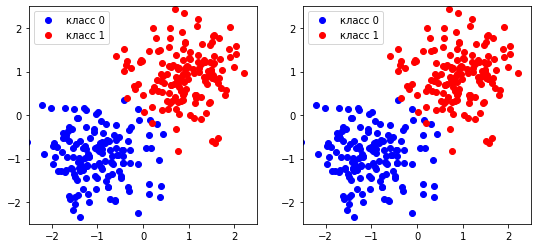

In [112]:
cols = ['blue', 'red', 'green']
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].set_xlim((-2.5, 2.5)), ax[i].set_ylim((-2.5, 2.5))

for k in np.unique(Y):
    ax[0].plot(X[Y==k,0], X[Y==k,1], 'o', 
               label='класс {}'.format(k), color=cols[k])
    ax[1].plot(X[Y==k,0], X[Y==k,1], 'o', 
               label='класс {}'.format(k), color=cols[k])

ax[0].legend(loc='best'), ax[1].legend(loc='best')
plt.show()

In [113]:
model = LogicClassifier(max_iter=1000)
print(model)
print(model.fit(X_train, Y_train, seed=0))
print(model.score(X_train, Y_train), model.score(X_test, Y_test))
print(classification_report(Y_test, model.predict(X_test)))

R(x) = 1
R(x) = 0.16 < x_0 < 1.95 AND -0.94 < x_1 < 2.65
0.924 0.9
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        25
           1       0.95      0.84      0.89        25

    accuracy                           0.90        50
   macro avg       0.91      0.90      0.90        50
weighted avg       0.91      0.90      0.90        50



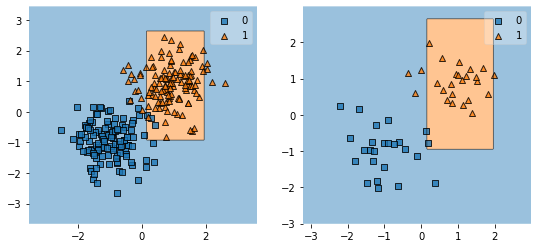

In [114]:
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))

plot_decision_regions(X_train, Y_train, model, ax=ax[0])
plot_decision_regions(X_test, Y_test, model, ax=ax[1])

plt.show()

In [84]:
model_2 = LogicClassifier(max_iter=1000, criteria='gini')
print(model_2)
print(model_2.fit(X_train, Y_train, seed=0))
print(model_2.score(X_train, Y_train), model_2.score(X_test, Y_test))
print(classification_report(Y_test, model_2.predict(X_test)))

R(x) = 1
R(x) = 0.98 < x_1 < 2.07 AND -1.09 < x_0 < 1.58
0.09016776237623769 0.09000000000000008
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        25
           1       1.00      0.40      0.57        25

    accuracy                           0.70        50
   macro avg       0.81      0.70      0.67        50
weighted avg       0.81      0.70      0.67        50



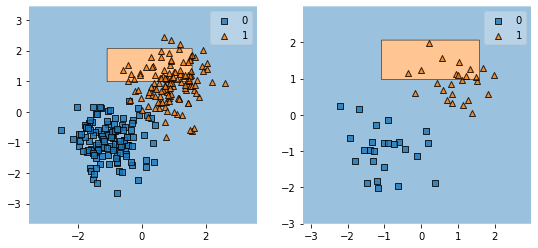

In [76]:
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))

plot_decision_regions(X_train, Y_train, model_2, ax=ax[0])
plot_decision_regions(X_test, Y_test, model_2, ax=ax[1])

plt.show()

In [95]:
model_3 = LogicClassifier(max_iter=1000, criteria='entropy')
print(model_3)
print(model_3.fit(X_train, Y_train, seed=0))
print(model_3.score(X_train, Y_train), model_3.score(X_test, Y_test))
print(classification_report(Y_test, model_3.predict(X_test)))

R(x) = 1
R(x) = -1.32 < x_0 < -0.26 AND -1.7 < x_1 < 1.21
0.08824457935307262 0.05792756891791773
              precision    recall  f1-score   support

           0       0.38      0.60      0.47        25
           1       0.09      0.04      0.06        25

    accuracy                           0.32        50
   macro avg       0.24      0.32      0.26        50
weighted avg       0.24      0.32      0.26        50



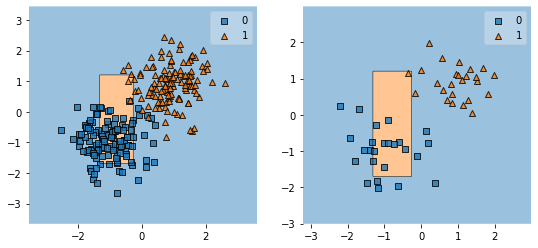

In [96]:
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))

plot_decision_regions(X_train, Y_train, model_3, ax=ax[0])
plot_decision_regions(X_test, Y_test, model_3, ax=ax[1])

plt.show()

In [115]:
model_4 = LogicClassifier(max_iter=1000, criteria='boost')
print(model_4)
print(model_4.fit(X_train, Y_train, seed=0))
print(model_4.score(X_train, Y_train), model_4.score(X_test, Y_test))
print(classification_report(Y_test, model_4.predict(X_test)))

R(x) = 1
R(x) = 0.45 < x_0 < 1.96 AND -1.54 < x_1 < 2.67
9.695359714832659 4.358898943540674
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        25
           1       1.00      0.76      0.86        25

    accuracy                           0.88        50
   macro avg       0.90      0.88      0.88        50
weighted avg       0.90      0.88      0.88        50



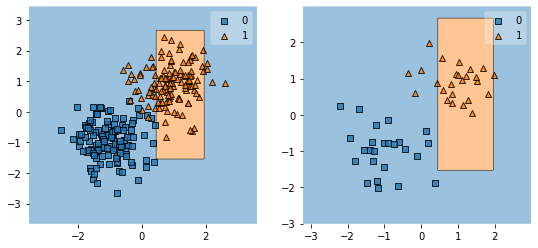

In [116]:
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))

plot_decision_regions(X_train, Y_train, model_4, ax=ax[0])
plot_decision_regions(X_test, Y_test, model_4, ax=ax[1])

plt.show()

### Более сложная выборка

In [97]:
X, Y = make_classification(n_samples=150, n_features=2, 
                           n_informative=2, n_classes=2, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=50, 
                                                    random_state=0)

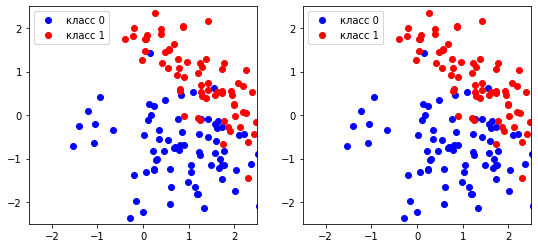

In [98]:
cols = ['blue', 'red', 'green']
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].set_xlim((-2.5, 2.5)), ax[i].set_ylim((-2.5, 2.5))

for k in np.unique(Y):
    ax[0].plot(X[Y==k,0], X[Y==k,1], 'o', 
               label='класс {}'.format(k), color=cols[k])
    ax[1].plot(X[Y==k,0], X[Y==k,1], 'o', 
               label='класс {}'.format(k), color=cols[k])

ax[0].legend(loc='best'), ax[1].legend(loc='best')
plt.show()

In [99]:
model = LogicClassifier(max_iter=1000)
print(model)
print(model.fit(X_train, Y_train, seed=0))
print(model.score(X_train, Y_train), model.score(X_test, Y_test))
print(classification_report(Y_test, model.predict(X_test)))

R(x) = 1
R(x) = 0.67 < x_1 < 2.41 AND -1.53 < x_0 < 2.67
0.71 0.8
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        27
           1       1.00      0.57      0.72        23

    accuracy                           0.80        50
   macro avg       0.86      0.78      0.78        50
weighted avg       0.85      0.80      0.79        50



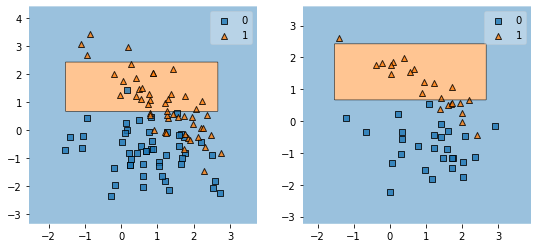

In [100]:
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))

plot_decision_regions(X_train, Y_train, model, ax=ax[0])
plot_decision_regions(X_test, Y_test, model, ax=ax[1])

plt.show()

### Выборка Wine

In [102]:
data = load_wine()
X = data['data']
Y = data['target']

X = X[Y < 2]
Y = Y[Y < 2]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=30, 
                                                    random_state=0)

In [103]:
model = LogicClassifier(max_iter=1000)
print(model)
print(model.fit(X_train, Y_train, seed=0))
print(model.score(X_train, Y_train), model.score(X_test, Y_test))
print(classification_report(Y_test, model.predict(X_test)))

R(x) = 1
R(x) = -0.97 < x_5 < 2.25
0.77 0.7333333333333333
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        16
           1       1.00      0.43      0.60        14

    accuracy                           0.73        30
   macro avg       0.83      0.71      0.70        30
weighted avg       0.82      0.73      0.71        30



## Критерии Информативности

1. энтропийный критерий:
$$
IGain\bigr(p, n\bigr) = h\bigr(\frac{P}{l}\bigr) - \frac{p+n}{l}h\bigr(\frac{p}{p+n}\bigr) - \frac{l-p-n}{l}h\bigr(\frac{P-p}{l-p-n}\bigr),
$$
где $h\bigr(q\bigr)=-q\log_2 q - \bigr(1-q\bigr)\log_2\bigr(1-q\bigr)$.
2. критерий Джини:
$$
IGini\bigr(p,n\bigr) = IGain\bigr(p,n\bigr), \quad  h\bigr(q\bigr)=4q\left(1-q\right)
$$
3. критерий буcтинга:
$$
BC\bigr(p, n\bigr) = \sqrt{p} - \sqrt{n}
$$

## Ансамблирование правил

1. Как видно было раньше, логические правила позволяют выделять одну область.
2. Но как было показано выше, в большинстве случаев этого не достаточно.
3. Для покрытия нескольких областей используем компизицию логических правил.


Простые решения:
1. Взвешенное голосование
2. Простое голосование
3. Решающий список

### Простой алгоритм для построения решающего списка


In [ ]:
np.random.seed(0)
l = 150
n = 2
X1 = np.array([[-1,-1] + [0]*(n-2)]) + 0.6*np.random.randn(l, n)
X2 = np.array([[1,1] + [0]*(n-2)]) + 0.6*np.random.randn(l, n)

X = np.vstack([X1, X2])
Y = np.hstack([[0]*l, [1]*l])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=50, 
                                                    random_state=0)

In [ ]:
model = LogicClassifier(max_iter=1000)
print(model)
print(model.fit(X_train, Y_train, seed=0))
print(model.score(X_train, Y_train), model.score(X_test, Y_test))
print(classification_report(Y_test, model.predict(X_test)))

In [ ]:
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))

plot_decision_regions(X_train, Y_train, model, ax=ax[0])
plot_decision_regions(X_test, Y_test, model, ax=ax[1])

plt.show()

In [ ]:
class LogicClassifierCommittee(object):
    def __init__(self, 
                 committee_size=3,
                 solver='random', 
                 criteria='accuracy', 
                 sigma=0.1, 
                 max_number_of_rules=20,
                 max_iter=100):
        
        if not isinstance(criteria, str):
            raise ValueError('criteria must be str format')
        if criteria not in {'accuracy'}:
            raise ValueError('criteria={} is not specified'.format(criteria))
        if not isinstance(committee_size, int):
            raise ValueError('committee_size must be int format')
        
        self.committee_size = committee_size
        self.criteria = criteria
        
        self.models = [LogicClassifier(
            solver, criteria, 
            sigma, max_number_of_rules, 
            max_iter) for _ in range(self.committee_size)]
        self.max_uses = self.committee_size
        
    def fit(self, X, Y, seed=0):
        index_used = set()
        for i in range(self.committee_size):
            model = self.models[i]
            index_can_use = list(set(range(len(X))) - index_used)
            if len(index_can_use):
                new_X = X[index_can_use, :]
                new_Y = Y[index_can_use]

                model.fit(new_X, new_Y, seed)

                index_used |= set(np.where(model.predict(X))[0])
            else:
                self.max_uses = i
                
        return self
    
    def __str__(self):
        return self.__repr__()
    
    def __repr__(self):
        others = []
        for i in range(self.max_uses):
            model = self.models[i]
            other = ' AND '.join(
                ['{} < x_{} < {}'.format(
                    round(model.R[1][j], 2), 
                    model.R[0][j], 
                    round(model.R[2][j], 2)) 
                 for j in range(len(model.R[0]))])
            if other:
                others.append('(' + other + ')')
        other = ' OR '.join(others)
        if other:
            ret = 'R(x) = ' + other
        else:
            ret = 'R(x) = 1'
        return ret
            
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        
        for i in range(self.max_uses):
            model = self.models[i]
            pred += model.predict(X)
            
        return np.array(pred > 0, dtype=np.int64)
        
    def score(self, X, Y):
        if self.criteria == 'accuracy':
            return np.mean(self.predict(X) == Y)

In [ ]:
model = LogicClassifierCommittee(max_iter=1000)
print(model)
print(model.fit(X_train, Y_train, seed=0))
print(model.score(X_train, Y_train), model.score(X_test, Y_test))
print(classification_report(Y_test, model.predict(X_test)))

In [ ]:
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))

plot_decision_regions(X_train, Y_train, model, ax=ax[0])
plot_decision_regions(X_test, Y_test, model, ax=ax[1])

plt.show()

## Деревья

In [117]:
np.random.seed(0)
l = 150
n = 2
X1 = np.array([[-1,-1] + [0]*(n-2)]) + 0.6*np.random.randn(l, n)
X2 = np.array([[1,1] + [0]*(n-2)]) + 0.6*np.random.randn(l, n)

X = np.vstack([X1, X2])
Y = np.hstack([[0]*l, [1]*l])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=50, 
                                                    random_state=0)

In [118]:
model = DecisionTreeClassifier(max_depth=2, random_state=0)
model.fit(X_train, Y_train)
print(model.score(X_train, Y_train), model.score(X_test, Y_test))
print(classification_report(Y_test, model.predict(X_test)))

0.984 0.98
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.96      1.00      0.98        25

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



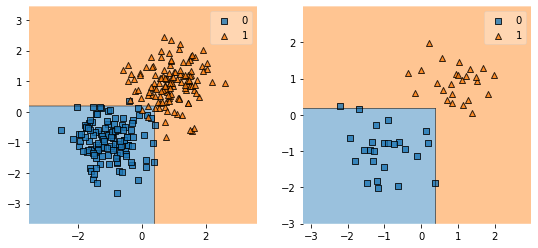

In [119]:
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))

plot_decision_regions(X_train, Y_train, model, ax=ax[0])
plot_decision_regions(X_test, Y_test, model, ax=ax[1])

plt.show()

In [120]:
text_representation = tree.export_text(model)
print(text_representation)

|--- feature_1 <= 0.18
|   |--- feature_0 <= 0.40
|   |   |--- class: 0
|   |--- feature_0 >  0.40
|   |   |--- class: 1
|--- feature_1 >  0.18
|   |--- feature_0 <= -0.38
|   |   |--- class: 1
|   |--- feature_0 >  -0.38
|   |   |--- class: 1



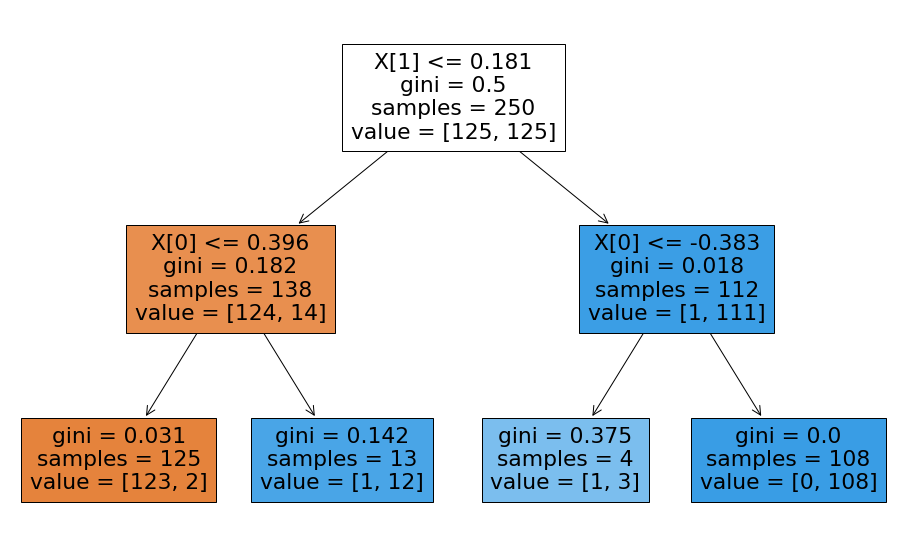

In [121]:
fig = plt.figure(figsize=(16,10))
_ = tree.plot_tree(model, filled=True)

### Посмотрим как область зависит от глубины деревьев

In [122]:
models = []
for depth in range(1, 5):
    model = DecisionTreeClassifier(max_depth=depth, random_state=0)
    model.fit(X_train, Y_train)
    models.append(model)

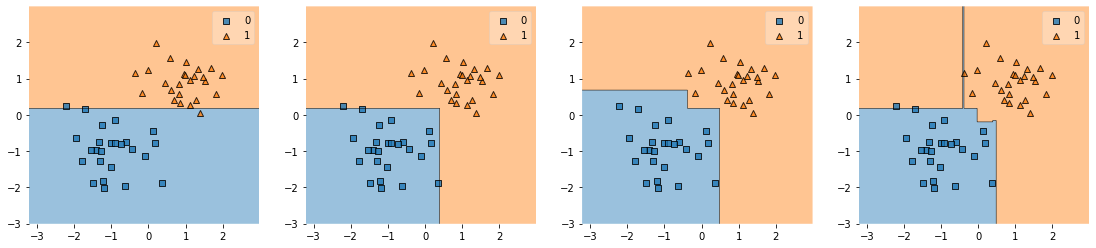

In [123]:
fig, gs = plt.figure(figsize=(19, 4)), gridspec.GridSpec(1, 4)

ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))

for i, model in enumerate(models):
    plot_decision_regions(X_test, Y_test, model, ax=ax[i])

plt.show()

### Выборка Wine

In [124]:
data = load_wine()
X = data['data']
Y = data['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=30, 
                                                    random_state=0)

In [125]:
model = DecisionTreeClassifier(max_depth=2, random_state=0)
model.fit(X_train, Y_train)
print(model.score(X_train, Y_train), model.score(X_test, Y_test))
print(classification_report(Y_test, model.predict(X_test)))

0.9391891891891891 0.7666666666666667
              precision    recall  f1-score   support

           0       0.64      1.00      0.78         9
           1       1.00      0.53      0.70        15
           2       0.75      1.00      0.86         6

    accuracy                           0.77        30
   macro avg       0.80      0.84      0.78        30
weighted avg       0.84      0.77      0.75        30



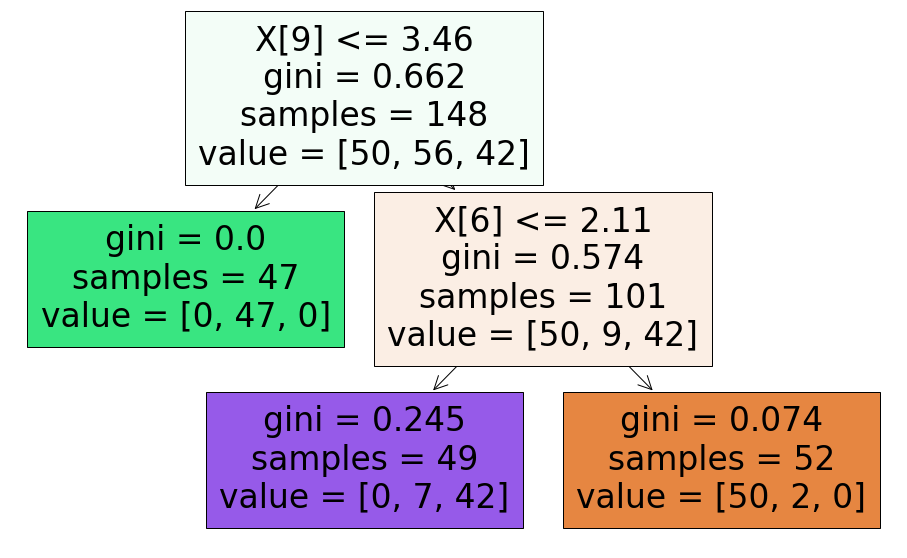

In [126]:
fig = plt.figure(figsize=(16,10))
_ = tree.plot_tree(model, filled=True)

### Выборка Boston

In [127]:
data = load_boston()
X = data['data']
Y = data['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=30, 
                                                    random_state=0)

In [ ]:
model = DecisionTreeRegressor(max_depth=3, random_state=0)
model.fit(X_train, Y_train)
print(model.score(X_train, Y_train), model.score(X_test, Y_test))

In [ ]:
fig = plt.figure(figsize=(16,10))
_ = tree.plot_tree(model, filled=True)

### Пример на синтетичеких одномерных данных

In [ ]:
np.random.seed(0)
l = 200
beta = 1.

X = np.linspace(-10, 10, l).reshape([-1, 1])
w = np.array([1., 1., 4.,])
Y = w[0] + w[1]*X[:, 0] + w[2]*np.sin(X[:, 0]) + beta*np.random.randn(l)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=50)

In [ ]:
plt.plot(X_train[:, 0], Y_train, '.')

plt.grid()
plt.show()

In [ ]:
model = DecisionTreeRegressor(max_depth=3, random_state=0)
model.fit(X_train, Y_train)
print(model.score(X_train, Y_train), model.score(X_test, Y_test))

In [ ]:
fig = plt.figure(figsize=(16,10))
_ = tree.plot_tree(model, filled=True)

In [ ]:
plt.plot(X_train[:, 0], Y_train, '.')

x = np.linspace(-10, 10, 2000)

plt.plot(x, model.predict(x.reshape(-1,1)))

plt.grid()
plt.show()

### Зависимость от глубины дерева

In [ ]:
models = []
for i in [3, 5, 9]:
    model = DecisionTreeRegressor(max_depth=i, random_state=0)
    model.fit(X_train, Y_train)
    models.append(model)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(X_train[:, 0], Y_train, '.', label='train')

x = np.linspace(-10, 10, 2000)
for model in models:
    plt.plot(x, model.predict(x.reshape(-1,1)), label=str(model.get_depth()))

plt.legend(loc='best')
plt.grid()
plt.show()

### Случайный лес
В данном случае мы говорим о множестве решающих деревьев (отсюда и слово лес).
1. Для задачи классификации в листях деревьев лежит класс.
2. Для задачи регресии в листях лежит среднее значение ответов для всех объектов.

Случайный лес является ансамблем деревьев:
1. Для каждого дерева выбирается произвольное подмножество объектов.
2. Строится каждое дерево не завиимо друг от друга.

In [ ]:
data = load_wine()
X = data['data']
Y = data['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=30, 
                                                    random_state=0)

In [ ]:
model = RandomForestClassifier(n_estimators=6, max_depth=2, random_state=0)
model.fit(X_train, Y_train)
print(model.score(X_train, Y_train), model.score(X_test, Y_test))
print(classification_report(Y_test, model.predict(X_test)))

### Зависимость качества от числа деревьев

In [ ]:
models = []
scores_train = []
scores_test = []
n_estimators = list(range(1, 20))
for estimators in n_estimators:
    model = RandomForestClassifier(n_estimators=estimators, random_state=0)
    model.fit(X_train, Y_train)
    models.append(model)
    scores_test.append(model.score(X_test, Y_test))
    scores_train.append(model.score(X_train, Y_train))

In [ ]:
plt.plot(n_estimators, scores_train, label='train')
plt.plot(n_estimators, scores_test, label='test')

plt.legend(loc='best')
plt.grid()
plt.show()

### Зависимость качества от числа признаков при расщеплении

In [ ]:
models = []
scores_train = []
scores_test = []
max_features = list(range(1, 13))
for features in max_features:
    model = RandomForestClassifier(n_estimators=6, 
                                   max_features=features, random_state=0)
    model.fit(X_train, Y_train)
    models.append(model)
    scores_test.append(model.score(X_test, Y_test))
    scores_train.append(model.score(X_train, Y_train))

In [ ]:
plt.plot(max_features, scores_train, label='train')
plt.plot(max_features, scores_test, label='test')

plt.legend(loc='best')
plt.grid()
plt.show()

### Зависимость качества от глубины деревьев

In [ ]:
models = []
scores_train = []
scores_test = []
current_depth = []
max_depth = list(range(1, 10))
for depth in max_depth:
    model = RandomForestClassifier(n_estimators=6,
        max_depth=depth, random_state=0)
    model.fit(X_train, Y_train)
    models.append(model)
    scores_test.append(model.score(X_test, Y_test))
    scores_train.append(model.score(X_train, Y_train))
    current_depth.append(model.estimators_[0].get_depth()/depth)

In [ ]:
plt.plot(max_depth, scores_train, label='train')
plt.plot(max_depth, scores_test, label='test')
plt.plot(max_depth, current_depth, label='real depth')

plt.legend(loc='best')
plt.grid()
plt.show()

### Замечания по случайному лесу
1. Число деревьев нужно подбирать, так как большое количество деревьев увеличивает качество на обучении, но на валидации, может быть меньше или не меняться вовсе, но время обучения возрастает.
2. Важным параметров является число признаков, которые участвуют в построении правила разделения. Для классификации обычно используется $\sqrt{n}$, а для регрессии $\frac{n}{3}$. Параметр является важным, так как при его увеличении деревья становятся похожими друг на друга.
3. Параметр глубины деревьев можно не подбирать, так как деревья сами настроивают эту высоту. Но если выборка слишком шумная, от рекомендуется не использовать слишком глубокие деревья.

P.S все параметры нужно подбирать на кросс-валидации.